Text classification example from: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [2]:
import pandas as pd
df = pd.read_csv('complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-02-11,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,NaN,NaN,First Data Corporation,WA,98109,NaN,NaN,Web,2020-02-11,In progress,Yes,NaN,3528370
1,2020-01-27,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,NaN,NaN,"EQUIFAX, INC.",GA,30238,NaN,NaN,Web,2020-01-27,In progress,Yes,NaN,3509918
2,2020-02-02,Debt collection,Medical debt,Written notification about debt,Didn't receive notice of right to dispute,NaN,NaN,"Commonwealth Financial Systems, Inc.",CA,95330,Servicemember,NaN,Web,2020-02-02,Closed with explanation,Yes,NaN,3517453
3,2020-02-11,Mortgage,FHA mortgage,Trouble during payment process,NaN,NaN,NaN,"FLAGSTAR BANK, FSB",NY,12182,NaN,NaN,Referral,2020-02-11,In progress,Yes,NaN,3528676
4,2020-02-06,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,NaN,"MONEY SOURCE, THE",MD,207XX,NaN,NaN,Web,2020-02-06,Closed with explanation,Yes,NaN,3522478


In [6]:
from io import StringIO
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
10,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...,0
35,"Credit reporting, credit repair services, or o...","XXXX XXXX XXXX, which went bankrupt a differen...",0
36,"Credit reporting, credit repair services, or o...",I kept receiving calls from a company stating ...,0
37,Debt collection,This is a reverse credit card complaint. \n\nM...,1
42,"Credit reporting, credit repair services, or o...",I was unable to request a security freeze with...,0


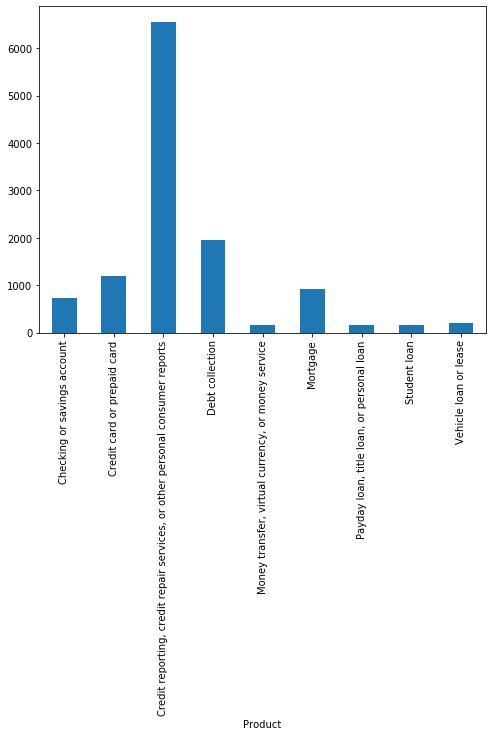

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

Text preprocessing and generation of text vector representations based on TF-IDF.
- `sublinear_tf` is set to `True` to use a logarithmic form for frequency.
- `min_df` is the minimum numbers of documents a word must be present in to be kept.
- `norm is set` to `l2`, to ensure all our feature vectors have a euclidian norm of 1.
- `ngram_range` is set to `(1, 2)` to indicate that we want to consider both unigrams and bigrams.
- `stop_words` is set to `"english"` to remove all common pronouns (`"a"`, `"the"`, ...) to reduce the number of noisy features.

In [8]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

CPU times: user 5.51 s, sys: 1.14 s, total: 6.65 s
Wall time: 6.68 s


(12013, 30009)

Showing the terms that are the most correlated with each of the products.

In [10]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Checking or savings account':
  . Most correlated unigrams:
. overdraft
. deposit
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. citi
. card
  . Most correlated bigrams:
. card company
. credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
. report
. accounts
  . Most correlated bigrams:
. bureaus reporting
. credit report
# 'Debt collection':
  . Most correlated unigrams:
. collect
. debt
  . Most correlated bigrams:
. debt does
. collect debt
# 'Money transfer, virtual currency, or money service':
  . Most correlated unigrams:
. western
. paypal
  . Most correlated bigrams:
. cash app
. western union
# 'Mortgage':
  . Most correlated unigrams:
. escrow
. mortgage
  . Most correlated bigrams:
. escrow account
. mortgage company
# 'Payday loan, title loan, or personal loan':
  . Most correlated unigrams:
. tower
. greensky
  . Most

### Model selection

In [11]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/alexandre/anaconda3/lib/python3.7/site-packages/sklearn/

CPU times: user 1min 49s, sys: 10.8 s, total: 2min
Wall time: 1min 52s


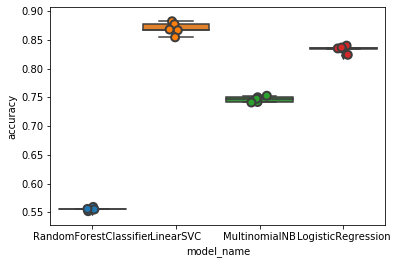

In [13]:
%matplotlib inline
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.869797
LogisticRegression        0.834175
MultinomialNB             0.746774
RandomForestClassifier    0.555650
Name: accuracy, dtype: float64

Best model evaluation

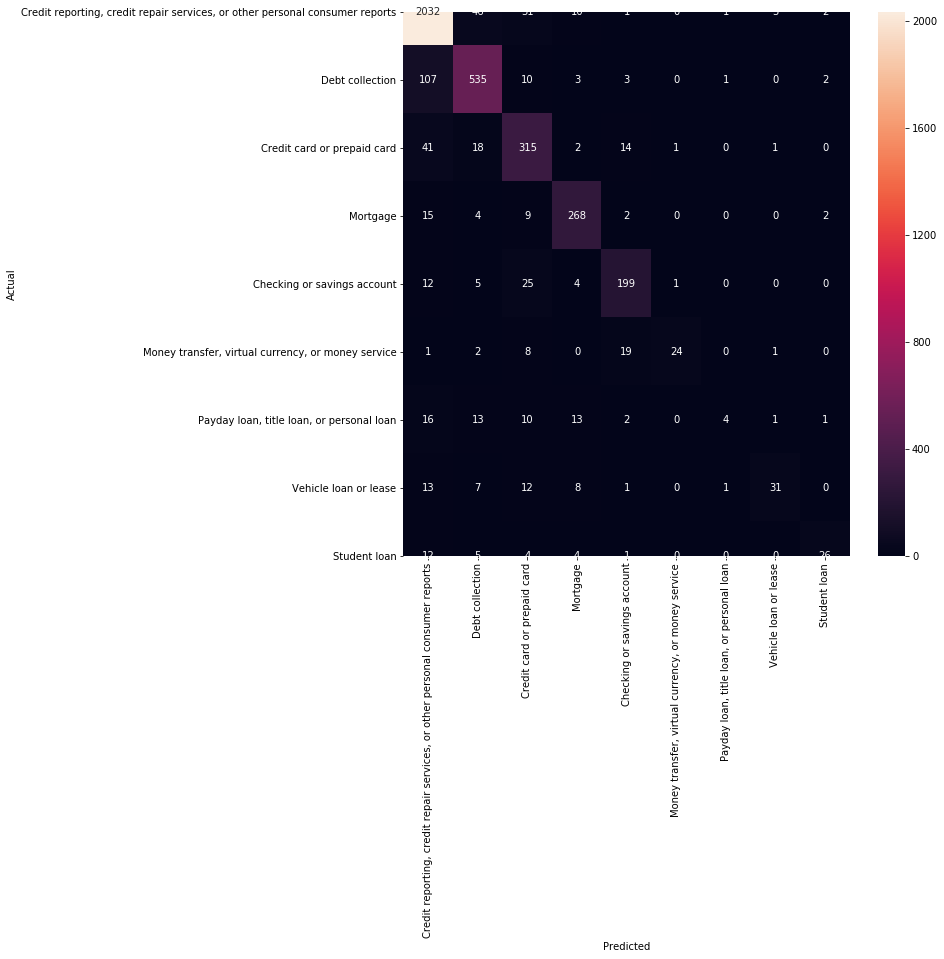

In [15]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Exploring misclassifications

In [17]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

'Debt collection' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 107 examples.


,Product,Consumer_complaint_narrative
42352,Debt collection,Ability Recovery Services continuously keeps r...
32354,Debt collection,IC System is reporting a false charge of {$400...
20770,Debt collection,XXXX XXXX XXXX responded on XX/XX/2019 with bu...
4852,Debt collection,I am writing to you to complain about Midwest ...
48304,Debt collection,I am writing to dispute an account fraudulentl...
...,...,...
7485,Debt collection,I did not receive the appropriate information ...
24795,Debt collection,"To whom it may concern, I look my credit repor..."
13163,Debt collection,"XX/XX/2020 received a "" balance verification '..."
40546,Debt collection,I am XXXX XXXX XXXX. I am in the U.S. XXXX and...



'Credit card or prepaid card' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 41 examples.


,Product,Consumer_complaint_narrative
39059,Credit card or prepaid card,My name is XXXX XXXX. I do not have my account...
8374,Credit card or prepaid card,The company didnt provide a resolution for thi...
19025,Credit card or prepaid card,SOMEONE STOLE MY IDENTITY AND OPENED A FRAUDUL...
11844,Credit card or prepaid card,"A fraudulent account was opened online, in my ..."
16089,Credit card or prepaid card,I was shocked when I reviewed my credit report...
31991,Credit card or prepaid card,This account was opened fraudulent. I reported...
44667,Credit card or prepaid card,PayPal security is blocking the use of my PayP...
28123,Credit card or prepaid card,XXXX Credit card has not been updated by Trans...
40847,Credit card or prepaid card,I have a PayPal Credit account where my FOUR p...
11516,Credit card or prepaid card,"On XX/XX/2019, I filed a compliant with CFPB a..."



'Mortgage' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 15 examples.


,Product,Consumer_complaint_narrative
7483,Mortgage,Hello how are you? Im having so many issues!!!...
20555,Mortgage,My payments are done with the auto payment ser...
13308,Mortgage,"I am requesting the following documents, elect..."
46354,Mortgage,Midland mortgage is reporting differently to a...
12115,Mortgage,Received company 's answer under Complaint # X...
7170,Mortgage,In XXXX the XXXX XXXX XXXX in their wise wis...
47284,Mortgage,"Per prior CFPB complaint, company has NOT rect..."
14386,Mortgage,Im still getting phone calls from this agency ...
6818,Mortgage,US Bank continues to fail to report payments o...
12354,Mortgage,Mortgage contract states a XXXX late fee will ...



'Checking or savings account' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 12 examples.


,Product,Consumer_complaint_narrative
13651,Checking or savings account,TDBank Allowed a transaction that was not app...
13479,Checking or savings account,I received a notice dated XX/XX/2020 that my a...
29245,Checking or savings account,My account was closed with no reason given to ...
17113,Checking or savings account,not sure how cybercrimes are handled but it's ...
3238,Checking or savings account,XXXX XXXX produced a fraudulent ex parte proba...
38927,Checking or savings account,"My name is XXXX XXXX XXXX, I am a XXXX year ol..."
9386,Checking or savings account,I filed a case : Complaint Number XXXX-XXXX. I...
21511,Checking or savings account,Mobile application will not allow all monthly ...
14534,Checking or savings account,Loan was paid off and a year later It shows ac...
3958,Checking or savings account,I had unauthorized money withdrawn from my XXX...



'Payday loan, title loan, or personal loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 16 examples.


,Product,Consumer_complaint_narrative
18068,"Payday loan, title loan, or personal loan",Cash aisles online payday loans charge XXXX fo...
34689,"Payday loan, title loan, or personal loan",On XX/XX/XXXX I received a credit monitoring a...
5031,"Payday loan, title loan, or personal loan",Mariner Finance sent me by mail an unsolicited...
11587,"Payday loan, title loan, or personal loan","Green Sky, LLC ( https : //www.greensky.com/ )..."
23768,"Payday loan, title loan, or personal loan",Do to multiple situational challenges it was r...
13769,"Payday loan, title loan, or personal loan",I have an account with a company called self l...
15523,"Payday loan, title loan, or personal loan",I entered on XXXX XXXX in the military on XXXX...
13458,"Payday loan, title loan, or personal loan","On XXXX XXXX, XXXX I went to a check cashing c..."
47320,"Payday loan, title loan, or personal loan","1. Around XX/XX/XXXX, I noticed a "" Hard Inqui..."
25754,"Payday loan, title loan, or personal loan",Payment wasnt due until XX/XX/XXXX they said t...



'Vehicle loan or lease' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 13 examples.


,Product,Consumer_complaint_narrative
8671,Vehicle loan or lease,on XXXX I obtained a auto loan with NC State E...
16047,Vehicle loan or lease,Global lending repossessed the car back in XXX...
14060,Vehicle loan or lease,We traded in our vehicle at a dealership when ...
4027,Vehicle loan or lease,"Account was closed keeps re appearing, account..."
6816,Vehicle loan or lease,"On XX/XX/2019, went to Larry H Miller used car..."
11859,Vehicle loan or lease,MEI auto finance continues to strong arm me on...
43283,Vehicle loan or lease,1 Payment that was made was not credited corre...
43011,Vehicle loan or lease,Credit acceptance appears to have violated the...
11928,Vehicle loan or lease,on XX/XX/2019 XXXX removed what was agreed to ...
6588,Vehicle loan or lease,My auto loan was paid off XX/XX/2019. \n\nI ov...



'Student loan' predicted as 'Credit reporting, credit repair services, or other personal consumer reports' : 12 examples.


,Product,Consumer_complaint_narrative
8487,Student loan,Since starting to make payments we are being b...
13896,Student loan,This is in reference to a case I opened 3 year...
28375,Student loan,To whomever it may concern : Thank you very mu...
8061,Student loan,Received post discharge monitoring form from N...
18049,Student loan,I called to have my account put on forbearance...
8370,Student loan,"On XX/XX/XXXX, I got a NASTY email from nelnet..."
12114,Student loan,Since loan inception I do not believe the comp...
5497,Student loan,I've contacted Nelnet via certified letter to ...
3667,Student loan,"Back between XXXX and XX/XX/2015, I requested ..."
30225,Student loan,when I called fed loan servicing to make a pay...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Debt collection' : 46 examples.


,Product,Consumer_complaint_narrative
15737,"Credit reporting, credit repair services, or o...",I have contacted the Credit Bureau several tim...
4881,"Credit reporting, credit repair services, or o...",This is false and misleading debt. I never att...
47339,"Credit reporting, credit repair services, or o...",Dear CFPB regarding complain ID XXXX and the c...
30893,"Credit reporting, credit repair services, or o...",The creditor XXXX XXXX I ask them to remove th...
33530,"Credit reporting, credit repair services, or o...",What continues to happen is that an old collec...
42347,"Credit reporting, credit repair services, or o...",XXXX was collecting on two XXXX XXXX XXXX deb...
565,"Credit reporting, credit repair services, or o...",Americollect agreed to send a letter to all cr...
19612,"Credit reporting, credit repair services, or o...",Two companies are at fault. The first agency i...
34170,"Credit reporting, credit repair services, or o...","On XXXX XX/XX/2019, I was informed by XXXX tha..."
28433,"Credit reporting, credit repair services, or o...",This company is reporting a Collection account...



'Credit card or prepaid card' predicted as 'Debt collection' : 18 examples.


,Product,Consumer_complaint_narrative
34605,Credit card or prepaid card,"Good Evening, i had an account with HSN, their..."
37638,Credit card or prepaid card,I tried to open an LOWE 'S Credit Card. LOWE '...
16470,Credit card or prepaid card,This kind of account is placed as a charged of...
23753,Credit card or prepaid card,Citibank sent my payment information via unsec...
4184,Credit card or prepaid card,On or about XX/XX/XXXX I contracted with XXXX ...
7379,Credit card or prepaid card,This kind of account is placed as a charged of...
6663,Credit card or prepaid card,Contacted XXXX XXXX to inform that I became il...
9402,Credit card or prepaid card,"I have repeatedly disputed this account, the c..."
15434,Credit card or prepaid card,This kind of account is placed as a charged of...
5372,Credit card or prepaid card,I had to file a previous complaint in order to...



'Payday loan, title loan, or personal loan' predicted as 'Debt collection' : 13 examples.


,Product,Consumer_complaint_narrative
1284,"Payday loan, title loan, or personal loan",In late 2013 I was late paying off a loan to C...
3759,"Payday loan, title loan, or personal loan","XX/XX/2020, I reached out to the company and a..."
5708,"Payday loan, title loan, or personal loan",The loan was for {$2500.00}. I have paid over ...
5059,"Payday loan, title loan, or personal loan","One Main Financial XXXX, TN Personal loan This..."
7797,"Payday loan, title loan, or personal loan",I called today because I received a letter abo...
14030,"Payday loan, title loan, or personal loan",This kind of account is placed as a charged of...
25083,"Payday loan, title loan, or personal loan",XXXX XXXX repeatedly calls and leaves voicemai...
18714,"Payday loan, title loan, or personal loan",I have been experiencing a substantial amount ...
6618,"Payday loan, title loan, or personal loan",Tried making payments and something happened t...
7915,"Payday loan, title loan, or personal loan",I received a loan for XXXX and I made two paym...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Credit card or prepaid card' : 31 examples.


,Product,Consumer_complaint_narrative
24194,"Credit reporting, credit repair services, or o...",This particular account situation that is late...
13445,"Credit reporting, credit repair services, or o...","I disputed this item, because it doesnt belong..."
32673,"Credit reporting, credit repair services, or o...",This particular account situation that is late...
45251,"Credit reporting, credit repair services, or o...",My husband and I left Washington state XX/XX/X...
6742,"Credit reporting, credit repair services, or o...",I had an issue with American Express. One of m...
37194,"Credit reporting, credit repair services, or o...",My Synchrony Bank/Chevron credit card was cha...
9905,"Credit reporting, credit repair services, or o...",Experian has charged me for 3 different times ...
15504,"Credit reporting, credit repair services, or o...",XX/XX/2019 Amount : {$1900.00} in accrued inte...
20283,"Credit reporting, credit repair services, or o...",This is in regards to complaint # XXXX-XXXX. \...
40778,"Credit reporting, credit repair services, or o...",In XX/XX/XXXX I attempted to open a phone acco...



'Debt collection' predicted as 'Credit card or prepaid card' : 10 examples.


,Product,Consumer_complaint_narrative
22167,Debt collection,I made a purchase at The Home Depot at XXXX XX...
23946,Debt collection,"In XXXX, I phone Sam 's Club Mastercard to clo..."
21480,Debt collection,XXXX XXXX v synchrony bank I havent used the s...
47476,Debt collection,"The credit card was opened for my Company, XXX..."
39368,Debt collection,"In XXXX, XXXX, I registered for a Citibank cre..."
7974,Debt collection,I purchased a cosmetic bag and 2 body products...
5959,Debt collection,This particular account situation that is late...
10004,Debt collection,I purchased a cosmetic bag and 2 body products...
44942,Debt collection,On XX/XX/2019 I became aware that a PayPal Cre...
6768,Debt collection,XXXX- XXXX I opened up a business account for...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 25 examples.


,Product,Consumer_complaint_narrative
19873,Checking or savings account,On XX/XX/XXXX I went to a festival downtown in...
23344,Checking or savings account,I have been calling Bank of America for 6 days...
17302,Checking or savings account,I disputed 2 transactions with Bank of America...
39236,Checking or savings account,I have been without my new ( renewed ) ATM Car...
38421,Checking or savings account,"Account Holder Very Concerned, the Union Bank ..."
47408,Checking or savings account,"As a long time Citibank credit card customer, ..."
4129,Checking or savings account,wells fargo refuses to refund my money\nafter ...
14054,Checking or savings account,This is my third situation dealing with incorr...
28034,Checking or savings account,"On Wednesday, XX/XX/XXXX, my son made a call t..."
19272,Checking or savings account,My Bank of America credit card was compromised...



'Payday loan, title loan, or personal loan' predicted as 'Credit card or prepaid card' : 10 examples.


,Product,Consumer_complaint_narrative
21986,"Payday loan, title loan, or personal loan",This particular account situation that is late...
13933,"Payday loan, title loan, or personal loan",The company is not disclosing the pay off if I...
14001,"Payday loan, title loan, or personal loan",This particular account situation that is late...
9083,"Payday loan, title loan, or personal loan","On XX/XX/ 2019, I received a call and email co..."
11955,"Payday loan, title loan, or personal loan",I applied on line for loans. My credit is bad...
8801,"Payday loan, title loan, or personal loan",I have had an account with Citi bank since XX/...
17026,"Payday loan, title loan, or personal loan",On XX/XX/2019 I was going through the checkout...
15297,"Payday loan, title loan, or personal loan",This particular account situation that is late...
34758,"Payday loan, title loan, or personal loan",This particular account situation that is late...
22031,"Payday loan, title loan, or personal loan",I purchased a Mattress around XX/XX/XXXX from ...



'Vehicle loan or lease' predicted as 'Credit card or prepaid card' : 12 examples.


,Product,Consumer_complaint_narrative
41261,Vehicle loan or lease,This particular account situation that is late...
28956,Vehicle loan or lease,"I fell behind on my payments, and my car was r..."
2230,Vehicle loan or lease,This particular account situation that is late...
12435,Vehicle loan or lease,XX/XX/XXXX on or about XXXX one XXXX truck was...
15885,Vehicle loan or lease,This particular account situation that is late...
23415,Vehicle loan or lease,Contact information correction on initial comp...
1012,Vehicle loan or lease,This particular account situation that is late...
7149,Vehicle loan or lease,their website will never work iv tried on two ...
19706,Vehicle loan or lease,This particular account situation that is late...
14747,Vehicle loan or lease,This particular account situation that is late...



'Credit reporting, credit repair services, or other personal consumer reports' predicted as 'Mortgage' : 10 examples.


,Product,Consumer_complaint_narrative
41875,"Credit reporting, credit repair services, or o...",My mortgage was sold to another mortgage compa...
1506,"Credit reporting, credit repair services, or o...",Being a customer of First Bank of Puerto Rico ...
39637,"Credit reporting, credit repair services, or o...",I had a B of A mortgage which has never been l...
32201,"Credit reporting, credit repair services, or o...",On my credit report XXXX XXXX XXXX pull my cre...
22291,"Credit reporting, credit repair services, or o...","Dear Sir or Madam, As discussed with the lende..."
27136,"Credit reporting, credit repair services, or o...",Please CFPB forward the documentation to Flags...
19100,"Credit reporting, credit repair services, or o...",Please check my payment history with US Bank M...
28712,"Credit reporting, credit repair services, or o...",I have been working with Equifax since XX/XX/X...
39937,"Credit reporting, credit repair services, or o...","Dear Sir or Madam, As discussed with the lende..."
16182,"Credit reporting, credit repair services, or o...",Ditech has been trying to say that I owe for a...



'Payday loan, title loan, or personal loan' predicted as 'Mortgage' : 13 examples.


,Product,Consumer_complaint_narrative
10863,"Payday loan, title loan, or personal loan",I am a beneficiary on the XXXX XXXX XXXX XXXX ...
6675,"Payday loan, title loan, or personal loan",XX/XX/2019 I received an email stating Refund ...
17569,"Payday loan, title loan, or personal loan",We have experienced several issues with this l...
37270,"Payday loan, title loan, or personal loan",I contacted Greensky on XXXX XX/XX/XXXX and pr...
9554,"Payday loan, title loan, or personal loan","On XX/XX/2019, I submitted a written email thr..."
10344,"Payday loan, title loan, or personal loan",I originated a line of credit with TD Bank on ...
8323,"Payday loan, title loan, or personal loan",I am writing on behalf of my father who does n...
9964,"Payday loan, title loan, or personal loan",I logged into my XXXX XXXX to check my credit....
3770,"Payday loan, title loan, or personal loan",I took out a XXXX dollar loan after I was assu...
39520,"Payday loan, title loan, or personal loan",My elderly veteran father was taken to Suntrus...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 14 examples.


,Product,Consumer_complaint_narrative
11935,Credit card or prepaid card,Transaction done at ATM. Bank is not disputing...
2283,Credit card or prepaid card,I was issued a check on XX/XX/2018 in the amou...
34835,Credit card or prepaid card,I am opening a new complaint because ( a ) I h...
42219,Credit card or prepaid card,Citibank approved me for multiple XXXX XXXX cr...
24958,Credit card or prepaid card,I made a double payment by mistake on XX/XX/XX...
37046,Credit card or prepaid card,I have an account with Wells Fargo bank here i...
12541,Credit card or prepaid card,NEVER RECEIVED {$10.00} BONUS DESCRIBED ON ATT...
29160,Credit card or prepaid card,"On XX/XX/2019, There were four unauthorized tr..."
2390,Credit card or prepaid card,I called Bank of America in order to ask if re...
32381,Credit card or prepaid card,Attempted to call to work with this bank but I...



'Money transfer, virtual currency, or money service' predicted as 'Checking or savings account' : 19 examples.


,Product,Consumer_complaint_narrative
22322,"Money transfer, virtual currency, or money ser...",I did not give any authorization for anyone to...
8338,"Money transfer, virtual currency, or money ser...",Chase bank in XXXX XXXX XXXX.. I deposit a XXX...
8412,"Money transfer, virtual currency, or money ser...",I bank with Bank of America and around XX/XX/2...
38561,"Money transfer, virtual currency, or money ser...",COMPLAINT ON BANK OF AMERICA CASE NUMBER -XXXX...
45647,"Money transfer, virtual currency, or money ser...",Re : Unauthorized XXXX transfer of {$800.00} f...
1511,"Money transfer, virtual currency, or money ser...",Earlier today XX/XX/2019 l received several tr...
12189,"Money transfer, virtual currency, or money ser...",I use Square Inc for CC processing at my busin...
5213,"Money transfer, virtual currency, or money ser...",Please note that I provide consent for the CFP...
16306,"Money transfer, virtual currency, or money ser...","Today at XXXX, XXXX 2019 at XXXX I sent {$100...."
7760,"Money transfer, virtual currency, or money ser...",I have never had the CashApp or any Square App...


In [18]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.90      0.96      0.93      2126
                                                             Debt collection       0.84      0.81      0.83       661
                                                 Credit card or prepaid card       0.74      0.80      0.77       392
                                                                    Mortgage       0.86      0.89      0.88       300
                                                 Checking or savings account       0.82      0.81      0.82       246
                          Money transfer, virtual currency, or money service       0.92      0.44      0.59        55
                                   Payday loan, title loan, or personal loan       0.57      0.07      0.12        60
                                                       